In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df1 = catalog.load('station_2')

2021-10-07 12:20:50,170 - kedro.io.data_catalog - INFO - Loading data from `station_2` (CSVDataSet)...


In [3]:
df1

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001.0,4UPUqMRk7TRMgml,0.0,0.0,9425.0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001.0,4UPUqMRk7TRMgml,0.0,0.0,9425.0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001.0,4UPUqMRk7TRMgml,0.0,0.0,9425.0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001.0,4UPUqMRk7TRMgml,0.0,0.0,9425.0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001.0,4UPUqMRk7TRMgml,0.0,0.0,7540.0,26.596148,25.088210,0.0
...,...,...,...,...,...,...,...,...,...
71803,2020-06-17 22:45:00,4136001.0,xoJJ8DcxJEcupym,0.0,0.0,4316.0,23.511703,22.856201,0.0
71804,2020-06-17 23:00:00,4136001.0,xoJJ8DcxJEcupym,0.0,0.0,4316.0,23.482282,22.744190,0.0
71805,2020-06-17 23:15:00,4136001.0,xoJJ8DcxJEcupym,0.0,0.0,4316.0,23.354743,22.492245,0.0
71806,2020-06-17 23:30:00,4136001.0,xoJJ8DcxJEcupym,0.0,0.0,4316.0,23.291048,22.373909,0.0


In [4]:
import matplotlib.cm as cm

In [ ]:
modules = df1.SOURCE_KEY.unique().tolist()
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(modules))]

_, ax = plt.subplots(1,1,figsize=(16,12))
ax.set_facecolor('lightgray')

for clr, key in zip(colors, modules):
    data = df1[df1.SOURCE_KEY == key]
    
    ax.plot(pd.to_datetime(data.DATE_TIME), data.AC_POWER, marker='', linestyle='-', color=clr, label=key)

plt.xticks(rotation=45)
plt.title('AC-power production capacity at 15 minute intervals', fontsize=20)
plt.show()


### Checking stationarity of series

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def adf_test(tseries):
    series_test = adfuller(tseries, autolag='AIC')
    output_series = pd.Series(series_test[0:4], index=['Test Statistic','p-value','Number Lags Used','Numer of Observations Used'])
    for key, value in series_test[4].items():
        output_series[f'Critical Value ({key})'] = value
    print(output_series)
    

In [ ]:
adf_test(df1.AC_POWER)

In [5]:
df1.DATE_TIME = pd.to_datetime(df1.DATE_TIME)

In [ ]:
df1_max_ind = df1.groupby(['SOURCE_KEY',pd.Grouper(freq='1D')])['DAILY_YIELD'].max().reset_index()

In [ ]:
result = adfuller(df1_max_ind[df1_max_ind.SOURCE_KEY == df1.SOURCE_KEY.unique()[0]].DAILY_YIELD.diff().dropna())

if result[0] < result[4]['5%']:
    if result[0] < result[4]['1%']:
        print('Series is stationary with 99% conf.')
    else:
        print('Series is stationary with 5% conf.')
else:
    print('Series is not stationary try differencing.')
        


In [ ]:
result

In [ ]:
_,ax = plt.subplots(1,1,figsize=(16,12))
plot_acf(df1_mean_all[df1_mean_all.SOURCE_KEY == df1.SOURCE_KEY.unique()[0]].DAILY_YIELD.diff().diff().dropna(), lags=15, ax=ax)
plt.show()

In [ ]:
modules = df1_mean_all.SOURCE_KEY.unique().tolist()
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(modules))]

_, ax = plt.subplots(1,1,figsize=(16,12))
ax.set_facecolor('lightgray')
for clr, key in zip(colors, modules):
    data = df1_mean_all[df1_mean_all.SOURCE_KEY == key]
    ax.plot(data.DATE_TIME, data.AC_POWER, color=clr, linestyle='-')
plt.show()

In [18]:
df1.set_index('DATE_TIME', inplace=True)

In [ ]:
df1_rolling_sum = df1.groupby(['SOURCE_KEY',pd.Grouper(freq='15T')])['AC_POWER'].sum().rolling(96).sum().shift(-96).dropna().reset_index()

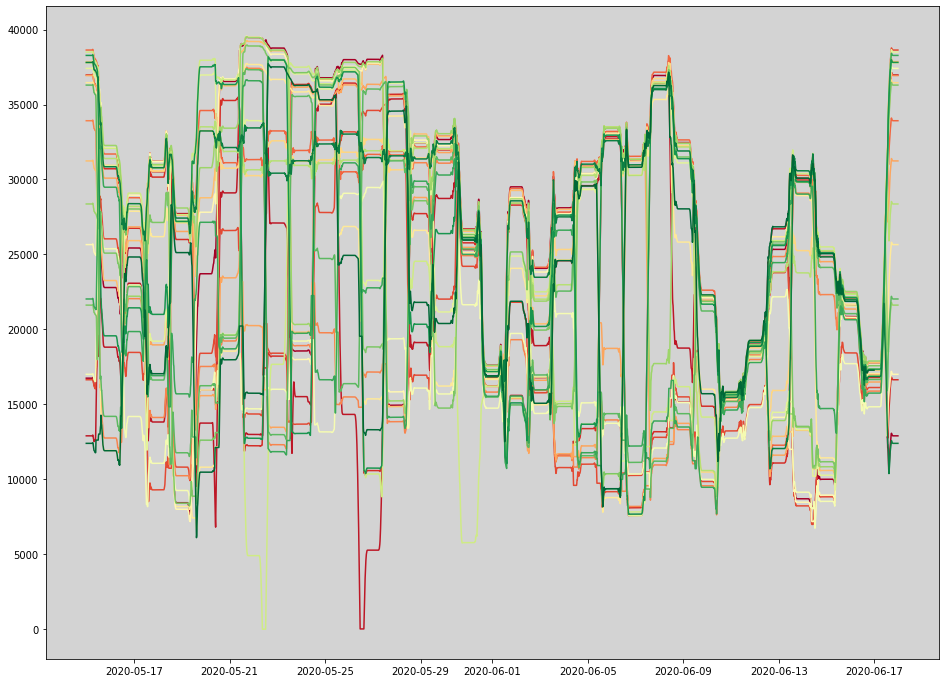

In [94]:
modules = df1_rolling_sum.SOURCE_KEY.unique().tolist()
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(modules))]

_, ax = plt.subplots(1,1,figsize=(16,12))
ax.set_facecolor('lightgray')
for clr, key in zip(colors, modules):
    data = df1_rolling_sum[df1_rolling_sum.SOURCE_KEY == key]
    ax.plot(data.DATE_TIME, data.AC_POWER, color=clr, linestyle='-')
plt.show()

In [ ]:
df1_rolling_day = df1.groupby(['SOURCE_KEY',pd.Grouper(freq='1D')])\
    ['AC_POWER'].sum()\
    .rolling(24).sum().shift(-24).dropna().reset_index()

In [ ]:
df1_rolling_day

In [ ]:
modules = df1_rolling_day.SOURCE_KEY.unique().tolist()
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(modules))]

_, ax = plt.subplots(1,1,figsize=(16,12))
ax.set_facecolor('lightgray')
for clr, key in zip(colors, modules):
    data = df1_rolling_day[df1_rolling_day.SOURCE_KEY == key]
    ax.plot(data.DATE_TIME, data.AC_POWER, color=clr, linestyle='-')
plt.show()

### different methods of sampling data:

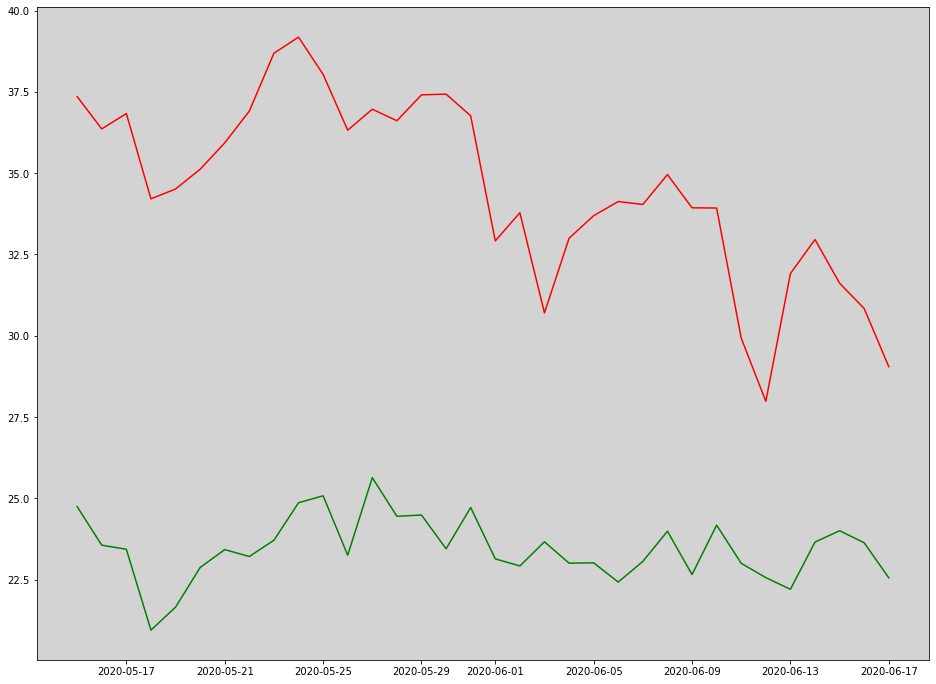

In [84]:
data = df1.groupby(pd.Grouper(freq='1D')).agg({'AMBIENT_TEMPERATURE':['max','min']})

_, ax = plt.subplots(1,1,figsize=(16,12))

ax.set_facecolor('lightgray')
ax.plot(data.index, data['AMBIENT_TEMPERATURE']['max'], color = 'red')
ax.plot(data.index, data['AMBIENT_TEMPERATURE']['min'], color = 'green')
plt.show()

In [93]:
df1[df1.IRRADIATION > 0].groupby(pd.Grouper(freq='1D'))['IRRADIATION'].count()/96

DATE_TIME
2020-05-15    12.145833
2020-05-16    12.375000
2020-05-17    13.291667
2020-05-18    12.833333
2020-05-19    14.437500
2020-05-20     8.979167
2020-05-21     9.937500
2020-05-22     9.937500
2020-05-23     9.937500
2020-05-24     9.937500
2020-05-25     9.937500
2020-05-26     9.937500
2020-05-27    10.312500
2020-05-28    10.125000
2020-05-29    10.208333
2020-05-30    12.145833
2020-05-31    14.208333
2020-06-01    11.687500
2020-06-02    12.145833
2020-06-03    11.916667
2020-06-04    12.604167
2020-06-05    12.145833
2020-06-06    12.375000
2020-06-07    12.833333
2020-06-08    12.375000
2020-06-09    12.375000
2020-06-10    13.750000
2020-06-11    13.291667
2020-06-12    12.604167
2020-06-13    12.145833
2020-06-14    12.833333
2020-06-15    12.604167
2020-06-16    12.375000
2020-06-17    12.604167
Freq: D, Name: IRRADIATION, dtype: float64

In [105]:
{val:item+1 for item, val in enumerate(df1[df1.IRRADIATION > 0].groupby(pd.Grouper(freq='1D'))['IRRADIATION'].count().index)}

{Timestamp('2020-05-15 00:00:00', freq='D'): 1,
 Timestamp('2020-05-16 00:00:00', freq='D'): 2,
 Timestamp('2020-05-17 00:00:00', freq='D'): 3,
 Timestamp('2020-05-18 00:00:00', freq='D'): 4,
 Timestamp('2020-05-19 00:00:00', freq='D'): 5,
 Timestamp('2020-05-20 00:00:00', freq='D'): 6,
 Timestamp('2020-05-21 00:00:00', freq='D'): 7,
 Timestamp('2020-05-22 00:00:00', freq='D'): 8,
 Timestamp('2020-05-23 00:00:00', freq='D'): 9,
 Timestamp('2020-05-24 00:00:00', freq='D'): 10,
 Timestamp('2020-05-25 00:00:00', freq='D'): 11,
 Timestamp('2020-05-26 00:00:00', freq='D'): 12,
 Timestamp('2020-05-27 00:00:00', freq='D'): 13,
 Timestamp('2020-05-28 00:00:00', freq='D'): 14,
 Timestamp('2020-05-29 00:00:00', freq='D'): 15,
 Timestamp('2020-05-30 00:00:00', freq='D'): 16,
 Timestamp('2020-05-31 00:00:00', freq='D'): 17,
 Timestamp('2020-06-01 00:00:00', freq='D'): 18,
 Timestamp('2020-06-02 00:00:00', freq='D'): 19,
 Timestamp('2020-06-03 00:00:00', freq='D'): 20,
 Timestamp('2020-06-04 00:00:

In [5]:
attempt = catalog.load('base_cat')

2021-10-07 10:43:42,469 - kedro.io.data_catalog - INFO - Loading data from `base_cat` (YAMLDataSet)...


In [9]:
attempt['revised_cat'].keys()

dict_keys(['type', 'filepath', 'save_args'])

In [10]:
attempt['yaml_test'] = {'here_isa_key':{'nested_key1':'entry_1','nested_key2':[1,2,3,4,5,6]}}

In [14]:
attempt.pop('yaml_test')

{'here_isa_key': {'nested_key1': 'entry_1', 'nested_key2': [1, 2, 3, 4, 5, 6]}}

In [15]:
attempt

{'gen1_p': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/01_raw/Plant_1_Generation_Data.csv'},
 'gen2_p': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/01_raw/Plant_2_Generation_Data.csv'},
 'gen1_w': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/01_raw/Plant_1_Weather_Sensor_Data.csv'},
 'gen2_w': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/01_raw/Plant_2_Weather_Sensor_Data.csv'},
 'station_1': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/02_intermediate/Plant_1_Complete.csv'},
 'station_2': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/02_intermediate/Plant_2_Complete.csv'},
 'all_stations': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/02_intermediate/full_plant.csv'},
 'daily_yield_ind': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/03_primary/daily_ind_max.csv'},
 'daily_yield_all': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/03_primary/daily_all_max.csv'},
 'ac_power_ind': {'type': 'pandas.CSVDataSet',
  'filepath': 'data/03_primary/acp_r

In [16]:
catalog.save('revised_cat',attempt)

2021-10-07 11:17:13,761 - kedro.io.data_catalog - INFO - Saving data to `revised_cat` (YAMLDataSet)...


In [20]:
df1.groupby(['PLANT_ID','SOURCE_KEY',pd.Grouper(freq='1D')])['DAILY_YIELD'].max().reset_index()#.groupby(['PLANT_ID',pd.Grouper(key='DATE_TIME',freq='1D')])['DAILY_YIELD'].mean().reset_index()


,PLANT_ID,SOURCE_KEY,DATE_TIME,DAILY_YIELD
0,4136001.0,4UPUqMRk7TRMgml,2020-05-15,9425.000000
1,4136001.0,4UPUqMRk7TRMgml,2020-05-16,5677.000000
2,4136001.0,4UPUqMRk7TRMgml,2020-05-17,6342.000000
3,4136001.0,4UPUqMRk7TRMgml,2020-05-18,7641.000000
4,4136001.0,4UPUqMRk7TRMgml,2020-05-19,7641.000000
...,...,...,...,...
743,4136001.0,xoJJ8DcxJEcupym,2020-06-13,6632.000000
744,4136001.0,xoJJ8DcxJEcupym,2020-06-14,7268.000000
745,4136001.0,xoJJ8DcxJEcupym,2020-06-15,7412.666667
746,4136001.0,xoJJ8DcxJEcupym,2020-06-16,6203.200000


In [5]:
type(context.params['stations'])

str